<a href="https://colab.research.google.com/github/PeacefulSlice/NN2022/blob/master/NN2022LR5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Лабораторна робота 5
##Convolutional Neural Networks and Computer Vision with TensorFlow
###Завдання
- На основі документу вирішити завдання класифікації зображень їжі для 3 класів з набору даних food101
- Індекси класів визначити індивідуально за залежностями: i1=n-1,i2=n+29,i3=n+59 (де і1,і2,і3 - індекс класу (починаючи з 0) у відсортованому за алфавітом наборі даних, n - номер за списком групи.
- Результати оформити у вигляді файлу з кодом для моделювання та візуалізації у форматі .ipynb
- Результати викласти у репозиторії GitHub (папка Lab5).
- Підготуватися до захисту лабораторрної роботи (пояснення коду, відповіді на запитання за темою)


Використані бібліотеки

In [ ]:
import zipfile
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from pathlib import Path
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense

ЗАвантаження даних

In [11]:
# Download zip file of pizza_steak images
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip 
# Unzip the downloaded file
zip_ref = zipfile.ZipFile("101_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

--2022-06-06 18:19:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 108.177.11.128, 74.125.134.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G   138MB/s    in 11s     

2022-06-06 18:20:09 (139 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



Вибір класів 

In [13]:
data_dir = pathlib.Path("101_food_classes_10_percent/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
my_class_names = [class_names[3], class_names[33], class_names[63]]
print(my_class_names)

['beignets', 'falafel', 'nachos']


Функція для виведення випадкового зображення з певного класу

Image shape: (512, 512, 3)


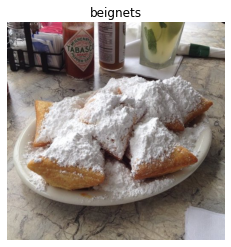

In [14]:
def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img
img = view_random_image(target_dir="101_food_classes_10_percent/train/",
                        target_class=my_class_names[0])

Image shape: (512, 512, 3)


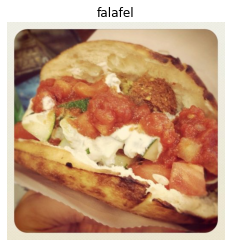

In [15]:
img = view_random_image(target_dir="101_food_classes_10_percent/train/",
                        target_class=my_class_names[1])

Image shape: (512, 512, 3)


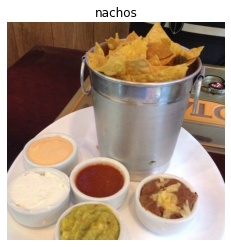

In [16]:
img = view_random_image(target_dir="101_food_classes_10_percent/train/",
                        target_class=my_class_names[2])

Залишаємо лише дані відповідні до варіанту

In [17]:
train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

for i in class_names:
  if i not in my_class_names:
    dirpath = Path(train_dir) / i
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath)
    dirpath = Path(test_dir) / i
    if dirpath.exists() and dirpath.is_dir():
        shutil.rmtree(dirpath) 
!ls 101_food_classes_10_percent/train/
!ls 101_food_classes_10_percent/test/

beignets  falafel  nachos
beignets  falafel  nachos


Беремо дані з директоріїв та перетворюємо на пакети

In [18]:
tf.random.set_seed(42)

train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(test_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(train_dir,
                                              target_size=(224, 224),
                                              batch_size=32,
                                              class_mode='categorical')

train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, 
                                             width_shift_range=0.2,
                                             height_shift_range=0.2,
                                             zoom_range=0.2,
                                             horizontal_flip=True)

train_data_augmented = train_datagen_augmented.flow_from_directory(test_dir,
                                                                  target_size=(224, 224),
                                                                  batch_size=32,
                                                                  class_mode='categorical')

Found 750 images belonging to 3 classes.
Found 225 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


Навчання мережі

In [ ]:
model = Sequential([
  Conv2D(32, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(32, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(3, activation='softmax')
])

model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

history_model = model.fit(train_data_augmented,
                          epochs=40,
                          steps_per_epoch=len(train_data_augmented),
                          validation_data=test_data,
                          validation_steps=len(test_data))


Створимо криві точності та втрат

In [ ]:
def plot_loss_curves(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();
plot_loss_curves(history_model)

In [ ]:
def load_and_prep_image(filename, img_shape=224):

  img = tf.io.read_file(filename)

  img = tf.image.decode_image(img, channels=3)

  img = tf.image.resize(img, size = [img_shape, img_shape])

  img = img/255.
  return img
def pred_and_plot(model, filename, class_names):
  img = load_and_prep_image(filename)

  pred = model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1: 
    pred_class = class_names[pred.argmax()] 
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] 

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);
pred_and_plot(model, "11.jpg", my_class_names)


Висновок
В ході лабораторної роботи вирішили завдання класифікації зображень їжі для 3 класів з набору даних food101